<a href="https://colab.research.google.com/github/PLEX-GR00T/NLP/blob/main/IR_and_EDA_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import math
import numpy as np
import json
import pandas as pd
import re
import string
from tqdm.notebook import tqdm

!pip3 install wikipedia-api > null
import wikipediaapi

from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_colwidth', -1)

# fix random seeds
seed_value = 42 

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

<ipython-input-3-0bca39801306>:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# TRIALLLLLLLLLLLLLS

with open("/content/drive/MyDrive/297_NLP/Final_Project/Merged_final_dataset.json", "r") as f:
    json_file = json.load(f)
data = json_file["data"]

# collect data for EDA
passages = []
questions = []
answer_index = []
answer_text = []

rows = []
for document in data:
    for passage in document['paragraphs']:
        passages.append(passage['context'])
        for qa in passage['qas']:
            for answer in qa['answers']:
                questions.append(qa['question'])
                answer_index.append((answer['answer_start'],answer['answer_end']))
                answer_text.append(answer['text'])

                # make a raw for the Panda data frame.
                rows.append(
                    {
                    'id' : qa['id'],
                    'doc_id': passage['document_id'],
                    'passage': passage['context'],
                    'question': qa['question'],
                    'answer_idx': (answer['answer_start'],answer['answer_end']),
                    'answer_text': answer['text']
                    }
                )

df_original = pd.DataFrame(rows)

In [ ]:
df_original.head()

,id,doc_id,passage,question,answer_idx,answer_text
0,597868,1202471,"Gabon, a country along the Atlantic coast of Central Africa, has significant areas of protected parkland. The forested coastal terrain of its famed Loango National Park shelters a diversity of wildlife, from gorillas and hippos to whales. Lop� National Park consists of mostly rainforest. Akanda National Park is known for its mangroves and tidal beaches.",What is the country known for?,"(106, 238)","The forested coastal terrain of its famed Loango National Park shelters a diversity of wildlife, from gorillas and hippos to whales."
1,597867,1202471,"Gabon, a country along the Atlantic coast of Central Africa, has significant areas of protected parkland. The forested coastal terrain of its famed Loango National Park shelters a diversity of wildlife, from gorillas and hippos to whales. Lop� National Park consists of mostly rainforest. Akanda National Park is known for its mangroves and tidal beaches.",What is the country?,"(0, 5)",Gabon
2,597870,1202471,"Gabon, a country along the Atlantic coast of Central Africa, has significant areas of protected parkland. The forested coastal terrain of its famed Loango National Park shelters a diversity of wildlife, from gorillas and hippos to whales. Lop� National Park consists of mostly rainforest. Akanda National Park is known for its mangroves and tidal beaches.",What is Akanda National Park known for?\n,"(289, 355)",Akanda National Park is known for its mangroves and tidal beaches.
3,597869,1202471,"Gabon, a country along the Atlantic coast of Central Africa, has significant areas of protected parkland. The forested coastal terrain of its famed Loango National Park shelters a diversity of wildlife, from gorillas and hippos to whales. Lop� National Park consists of mostly rainforest. Akanda National Park is known for its mangroves and tidal beaches.",Where is the country located?\n,"(17, 59)",along the Atlantic coast of Central Africa
4,597868,1202474,"Germany is a Western European country with a landscape of forests, rivers, mountain ranges and North Sea beaches. It has over 2 millennia of history. Berlin, its capital, is home to art and nightlife scenes, the Brandenburg Gate and many sites relating to WWII. Munich is known for its Oktoberfest and beer halls, including the 16th-century Hofbr�uhaus. Frankfurt, with its skyscrapers, houses the European Central Bank.",What is the country known for?,"(174, 260)","home to art and nightlife scenes, the Brandenburg Gate and many sites relating to WWII"


In [ ]:
#@title preprocessing { form-width: "25%" }

import nltk
import re 
import math
import random as rand

nltk.download('punkt')
from nltk.stem.porter import PorterStemmer # for stemming
from tqdm.notebook import tqdm

def preprocess_text(text):
    REPLACE_WITH_SPACE = re.compile(r"\n") 
    text = [REPLACE_WITH_SPACE.sub(" ", line) for line in text]
    text = [re.sub(r"([(.;:!\'ˈ~?,\"(\[\])\\\/\-–\t```<>_#$€@%*+—°′″“”×’^₤₹‘])", r'', line) for line in text]
    # we noticed that in the text sometimes we find numbers and the following word merged together (ex: 1980february),
    # so we put a space between the number and the word
    text = [re.sub(r"(\d+)([a-z]+)", r'\1 \2', line) for line in text] 
    text = [re.sub('\s{2,}', ' ', line.strip()) for line in text]   # replacing more than one consecutive blank spaces with only one of them
    return text

# Creating a copy of the original dataframe (we do this because we want to be able to compare the results of our processing with the original data)
df = df_original.copy()

# pre-process passage and question text
df['passage'] = preprocess_text(df_original['passage'])
df['question'] = preprocess_text(df_original['question'])
df['answer_text'] = preprocess_text(df_original['answer_text'])

# Comparing Original and Pre-Processed
for i in range(3):
    a = rand.randint(0,1000)
    print('--------------ORIGINAL AND PREPROCESSED PASSAGE:-----------------')
    print(df_original.iloc[a]['passage'])
    print(df.iloc[a]['passage'])
    
    print()
    print('-------------ORIGINAL AND PREPROCESSED QUESTION:---------------')
    print(df_original.iloc[a]['question'])
    print(df.iloc[a]['question'])
    print()

df["passage"]=df["passage"].str.lower()
df["question"]=df["question"].str.lower()
df["answer_text"]=df["answer_text"].str.lower()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


--------------ORIGINAL AND PREPROCESSED PASSAGE:-----------------
Ukraine (Ukrainian: Україна, romanized: Ukraïna, pronounced [ʊkrɐˈjinɐ] (listen)) is a country in Eastern Europe. It is the second-largest European country after Russia, which it borders to the east and northeast.[a][11] Ukraine covers approximately 600,000 square kilometres (230,000 sq mi).[b] Prior to the ongoing Russo-Ukrainian War, it was the eighth-most populous country in Europe, with a population of around 41 million people.[c][6] It is also bordered by Belarus to the north; by Poland, Slovakia, and Hungary to the west; and by Romania and Moldova[d] to the southwest; with a coastline along the Black Sea and the Sea of Azov to the south and southeast.[e] Kyiv is the nation's capital and largest city. The country's national language is Ukrainian, and most people are also fluent in Russian.[14]

During the Middle Ages, the area was a key centre of East Slavic culture under the state of Kievan Rus', which emerged in t

In [ ]:
df = df.set_index('id')
df_original = df_original.set_index('id')

In [ ]:
df.head()

,doc_id,passage,question,answer_idx,answer_text
id,,,,,
597868,1202471,gabon a country along the atlantic coast of central africa has significant areas of protected parkland the forested coastal terrain of its famed loango national park shelters a diversity of wildlife from gorillas and hippos to whales lop� national park consists of mostly rainforest akanda national park is known for its mangroves and tidal beaches,what is the country known for,"(106, 238)",the forested coastal terrain of its famed loango national park shelters a diversity of wildlife from gorillas and hippos to whales
597867,1202471,gabon a country along the atlantic coast of central africa has significant areas of protected parkland the forested coastal terrain of its famed loango national park shelters a diversity of wildlife from gorillas and hippos to whales lop� national park consists of mostly rainforest akanda national park is known for its mangroves and tidal beaches,what is the country,"(0, 5)",gabon
597870,1202471,gabon a country along the atlantic coast of central africa has significant areas of protected parkland the forested coastal terrain of its famed loango national park shelters a diversity of wildlife from gorillas and hippos to whales lop� national park consists of mostly rainforest akanda national park is known for its mangroves and tidal beaches,what is akanda national park known for,"(289, 355)",akanda national park is known for its mangroves and tidal beaches
597869,1202471,gabon a country along the atlantic coast of central africa has significant areas of protected parkland the forested coastal terrain of its famed loango national park shelters a diversity of wildlife from gorillas and hippos to whales lop� national park consists of mostly rainforest akanda national park is known for its mangroves and tidal beaches,where is the country located,"(17, 59)",along the atlantic coast of central africa
597868,1202474,germany is a western european country with a landscape of forests rivers mountain ranges and north sea beaches it has over 2 millennia of history berlin its capital is home to art and nightlife scenes the brandenburg gate and many sites relating to wwii munich is known for its oktoberfest and beer halls including the 16 thcentury hofbr�uhaus frankfurt with its skyscrapers houses the european central bank,what is the country known for,"(174, 260)",home to art and nightlife scenes the brandenburg gate and many sites relating to wwii


In [ ]:
#@title train-test split { form-width: "25%" }

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

split_value = 0.1 #@param {type:"number"} 
test_dim = int(len(df['doc_id'].unique()) * split_value)
test_titles = np.random.choice(df['doc_id'].unique(), size=test_dim, replace=False)

# creating train and test sets
df_test = df[df['doc_id'].isin(test_titles)]
df_train = df[~(df['doc_id'].isin(test_titles))]

df_original_test = df_original[df_original['doc_id'].isin(test_titles)]
df_original_train = df_original[~(df_original['doc_id'].isin(test_titles))]

In [ ]:
df_test.tail()

,doc_id,passage,question,answer_idx,answer_text
id,,,,,
597604,1267010,papua new guinea officially12 the independent state of papua new guinea tok pisin independen stet bilong papua niugini hiri motu independen stet bilong papua niu gini is a country in oceania that comprises the eastern half of the island of new guinea and its offshore islands in melanesia a region of the southwestern pacific ocean north of australia its capital located along its southeastern coast is port moresby the country is the worlds third largest island country with an area of 462840 km2 178700 sq mi,what is the capital,"(417, 429)",port moresby
597688,1267010,papua new guinea officially12 the independent state of papua new guinea tok pisin independen stet bilong papua niugini hiri motu independen stet bilong papua niu gini is a country in oceania that comprises the eastern half of the island of new guinea and its offshore islands in melanesia a region of the southwestern pacific ocean north of australia its capital located along its southeastern coast is port moresby the country is the worlds third largest island country with an area of 462840 km2 178700 sq mi,which place is this,"(0, 16)",papua new guinea
597603,1267010,papua new guinea officially12 the independent state of papua new guinea tok pisin independen stet bilong papua niugini hiri motu independen stet bilong papua niu gini is a country in oceania that comprises the eastern half of the island of new guinea and its offshore islands in melanesia a region of the southwestern pacific ocean north of australia its capital located along its southeastern coast is port moresby the country is the worlds third largest island country with an area of 462840 km2 178700 sq mi,where is it located,"(192, 199)",oceania
597605,1267010,papua new guinea officially12 the independent state of papua new guinea tok pisin independen stet bilong papua niugini hiri motu independen stet bilong papua niu gini is a country in oceania that comprises the eastern half of the island of new guinea and its offshore islands in melanesia a region of the southwestern pacific ocean north of australia its capital located along its southeastern coast is port moresby the country is the worlds third largest island country with an area of 462840 km2 178700 sq mi,whats the size of the place,"(504, 531)",462840 km2 178700 sq mi
597606,1267010,papua new guinea officially12 the independent state of papua new guinea tok pisin independen stet bilong papua niugini hiri motu independen stet bilong papua niu gini is a country in oceania that comprises the eastern half of the island of new guinea and its offshore islands in melanesia a region of the southwestern pacific ocean north of australia its capital located along its southeastern coast is port moresby the country is the worlds third largest island country with an area of 462840 km2 178700 sq mi,which country is this,"(0, 16)",papua new guinea


In [ ]:
df_train.shape

(1041, 5)

In [ ]:
#@title Define TFIDF { form-width: "25%" }
# defining the TF-IDF
tfidf_configs = {
    'lowercase': True,
    'analyzer': 'word',
    'stop_words': 'english',
    'binary': True,
    'max_df': 0.9,
    'max_features': 10_000
}
# defining the number of documents to retrieve
retriever_configs = {
    'metric': 'cosine'
}

# defining our pipeline
#embedding = TfidfVectorizer(**tfidf_configs)
# retriever = NearestNeighbors(**retriever_configs)

In [ ]:
#@title TFIDF { form-width: "25%" }
vectorizer =  TfidfVectorizer(**tfidf_configs)

## -------- to compare, get uniques from train set-----------##
# get unique preprocessed passages from the training set
unique_train = df_train['passage'].unique().tolist()
# use the tf-idf vectorizer to learn the vocabulary and the inverse document frequency, computing the document-term matrix on the training set
unique_train_tf_idf = vectorizer.fit_transform(unique_train)


## -------------------Unique for Testing set -------------##
# obtain unique passages from the test set
unique_test = df_test['passage'].unique().tolist() # preprocessed
passage_test = df_test['passage'].unique()

# transform test passages and questions
passage_test_tf_idf = vectorizer.transform(unique_test)
question_tf_idf = vectorizer.transform(df_test['question'].tolist())

# compute similarity
results = cosine_similarity(passage_test_tf_idf, question_tf_idf)

  0%|          | 0/13 [00:00<?, ?it/s]

[0.30392156862745096, 0.39215686274509803, 0.46078431372549017, 0.5098039215686274, 0.5392156862745098, 0.5882352941176471, 0.6568627450980392, 0.696078431372549, 0.7156862745098039, 0.7254901960784313, 0.7450980392156863, 0.7745098039215687, 0.803921568627451]


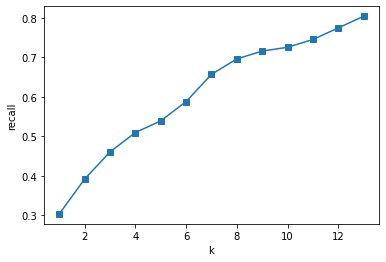

In [ ]:
#@title Recall Score { form-width: "25%" }

# In this cell we evaluate how effective is tf-idf in finding the right passage for a question

# we compute the result recall for each k between 1 and k_results:
# in particular, for each question we take the k most probable passages and check
# if the right passage is among them 
k_results = 13

tp = 0 #true positives
recall = []
for k in tqdm(range(1, k_results+1)):
    for j,result in enumerate(results.T):
        result = np.argsort(result)
        if df_test['passage'].tolist()[j] in [text for text in passage_test[result[-k:].tolist()]]:
            tp+=1
    recall.append(tp/len(df_test))
    tp = 0

print(recall,sep='\n')
plt.plot(list(range(1, k_results+1)),recall,"-s");
plt.xlabel("k");
plt.ylabel("recall");

> EDA

In [ ]:
df.head()

,doc_id,passage,question,answer_idx,answer_text
id,,,,,
597868,1202471,gabon a country along the atlantic coast of central africa has significant areas of protected parkland the forested coastal terrain of its famed loango national park shelters a diversity of wildlife from gorillas and hippos to whales lop� national park consists of mostly rainforest akanda national park is known for its mangroves and tidal beaches,what is the country known for,"(106, 238)",the forested coastal terrain of its famed loango national park shelters a diversity of wildlife from gorillas and hippos to whales
597867,1202471,gabon a country along the atlantic coast of central africa has significant areas of protected parkland the forested coastal terrain of its famed loango national park shelters a diversity of wildlife from gorillas and hippos to whales lop� national park consists of mostly rainforest akanda national park is known for its mangroves and tidal beaches,what is the country,"(0, 5)",gabon
597870,1202471,gabon a country along the atlantic coast of central africa has significant areas of protected parkland the forested coastal terrain of its famed loango national park shelters a diversity of wildlife from gorillas and hippos to whales lop� national park consists of mostly rainforest akanda national park is known for its mangroves and tidal beaches,what is akanda national park known for,"(289, 355)",akanda national park is known for its mangroves and tidal beaches
597869,1202471,gabon a country along the atlantic coast of central africa has significant areas of protected parkland the forested coastal terrain of its famed loango national park shelters a diversity of wildlife from gorillas and hippos to whales lop� national park consists of mostly rainforest akanda national park is known for its mangroves and tidal beaches,where is the country located,"(17, 59)",along the atlantic coast of central africa
597868,1202474,germany is a western european country with a landscape of forests rivers mountain ranges and north sea beaches it has over 2 millennia of history berlin its capital is home to art and nightlife scenes the brandenburg gate and many sites relating to wwii munich is known for its oktoberfest and beer halls including the 16 thcentury hofbr�uhaus frankfurt with its skyscrapers houses the european central bank,what is the country known for,"(174, 260)",home to art and nightlife scenes the brandenburg gate and many sites relating to wwii


In [ ]:
# list
# passages = []
# questions = []
# answer_index = []
# answer_text = []

In [ ]:
print(len(passages))
print(len(questions))
print(len(answer_index))
print(len(answer_text))

188
1143
1143
1143


In [ ]:
print(len(passages[187]))

450


In [ ]:
def plot_sns(raw_data,fig_name,fig_size,plot_type,xlabel,ylabel,title):

    data = np.array(raw_data)
    # print(len(data))

    x = np.arange(len(raw_data))
    # print(len(x))
    width = 0.2  # width of bar

    sns.axes_style('white')
    sns.set_style('white')
    sns.set(rc={'figure.figsize':fig_size})

    
    print(data)
    ax = plot_type(x, data)
    ax.tick_params(axis='x', rotation=90)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)

    fig = ax.get_figure()
    fig.savefig('/content/drive/MyDrive/297_NLP/Final_Project/'+ fig_name, dpi = 400) 

[ 355  420  411  418  373  238  412  647  700  421  257  286  410  392
  412  314  405  356  402  411  313  376  387  410  229  414  384  413
  407  372  387  418  381  406  265  269  418  280  812  385  666  890
  646  513  960 1023  552  666  753  471  871  652  843  785  476  852
  789  646 1025  788 1345  952  543  381  370  498  933  308  366 1239
  983  536  811  829  512  503  655  151  283  865  610  909 1206  371
  612  754  848  716  563  524 1520 1451 2925 1737 1105 1822 1122 1076
 1130 2190 1251 1223 2034  966 1652  756 1307 1780 1692 1053 1051 1173
 1183  911  670 1201  808 1637 1736 1334 1842 1233 1714 1202 1821 1351
 1789 1163 1503 1834 1233 1822 1259 1475 1008 1672  935 1411 1540 1819
 1507  704  692  788  841 1004  935  996  783  729  869  940  587  524
  548  672  630 1135 1051  634  597 1080 1027  604  993  680  856  624
  591  638  802  631  720  800  799  771  894 1058  582  628  649  619
  711  532  828  450  575  450]


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


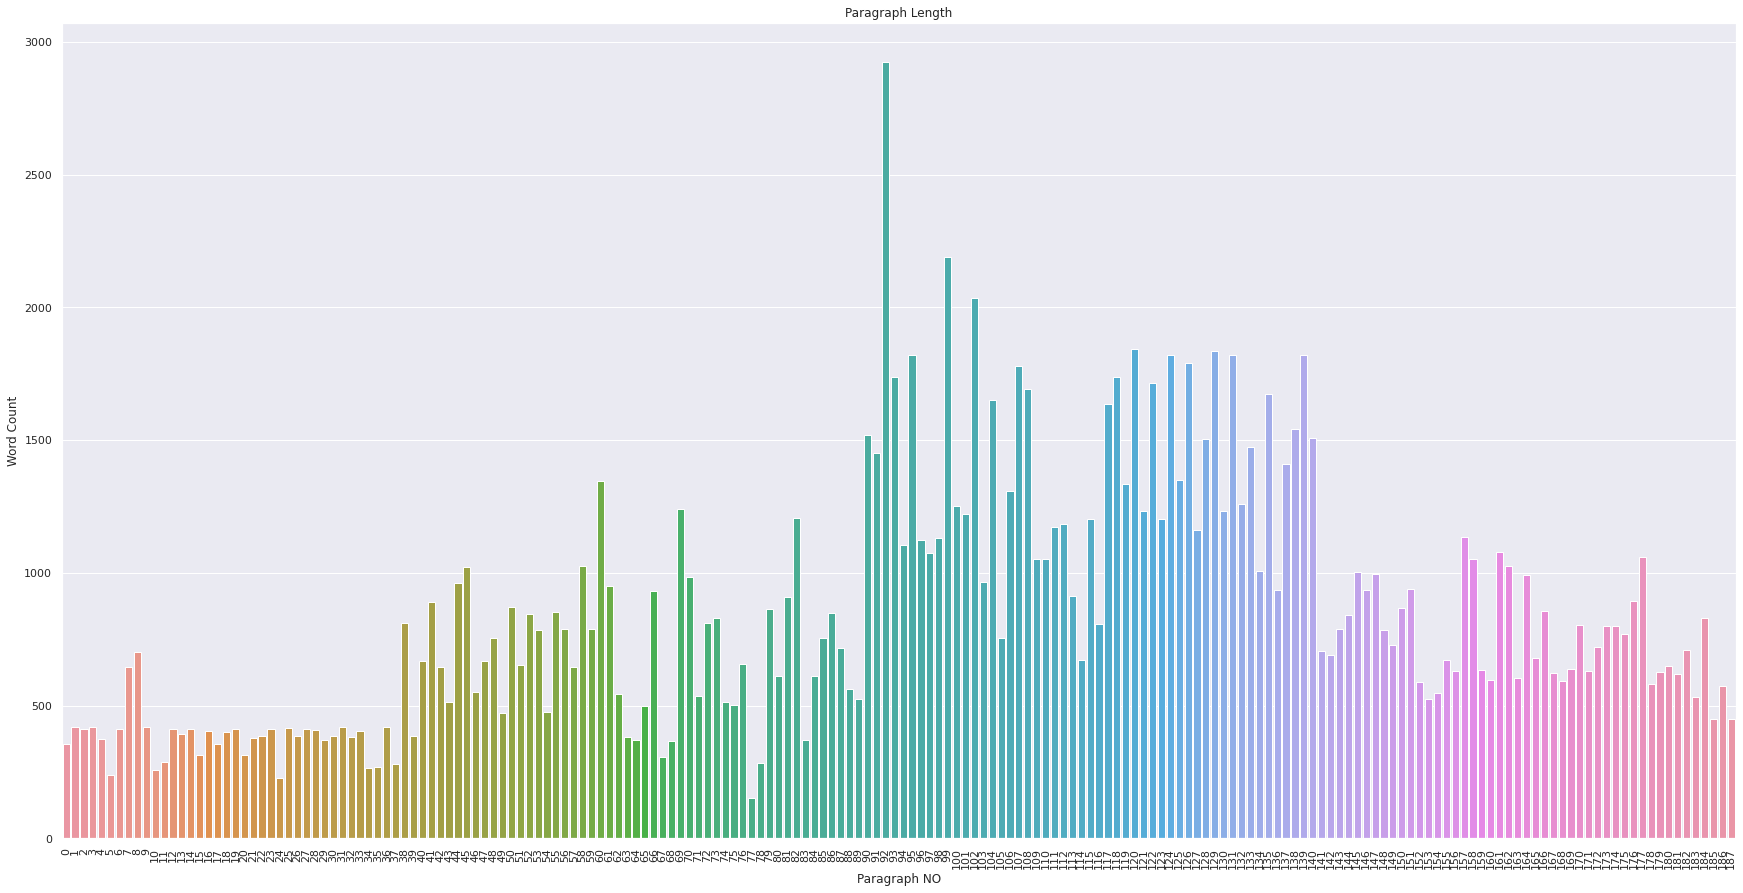

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  

passage_len = []

for i in range(0,len(passages)):
    passage_len.append(len(passages[i]))

# print((passage_len))
plot_sns(passage_len, 'paragraph_len', (30,15), sns.barplot, xlabel = "Paragraph NO", ylabel = "Word Count", title = "Paragraph Length")

In [ ]:
passage_MMA = {'max':max(passage_len),'min':min(passage_len),'avg':np.average(passage_len)}
print(passage_MMA)

{'max': 2925, 'min': 151, 'avg': 844.0904255319149}


[30 20 40 ... 36 22 42]


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


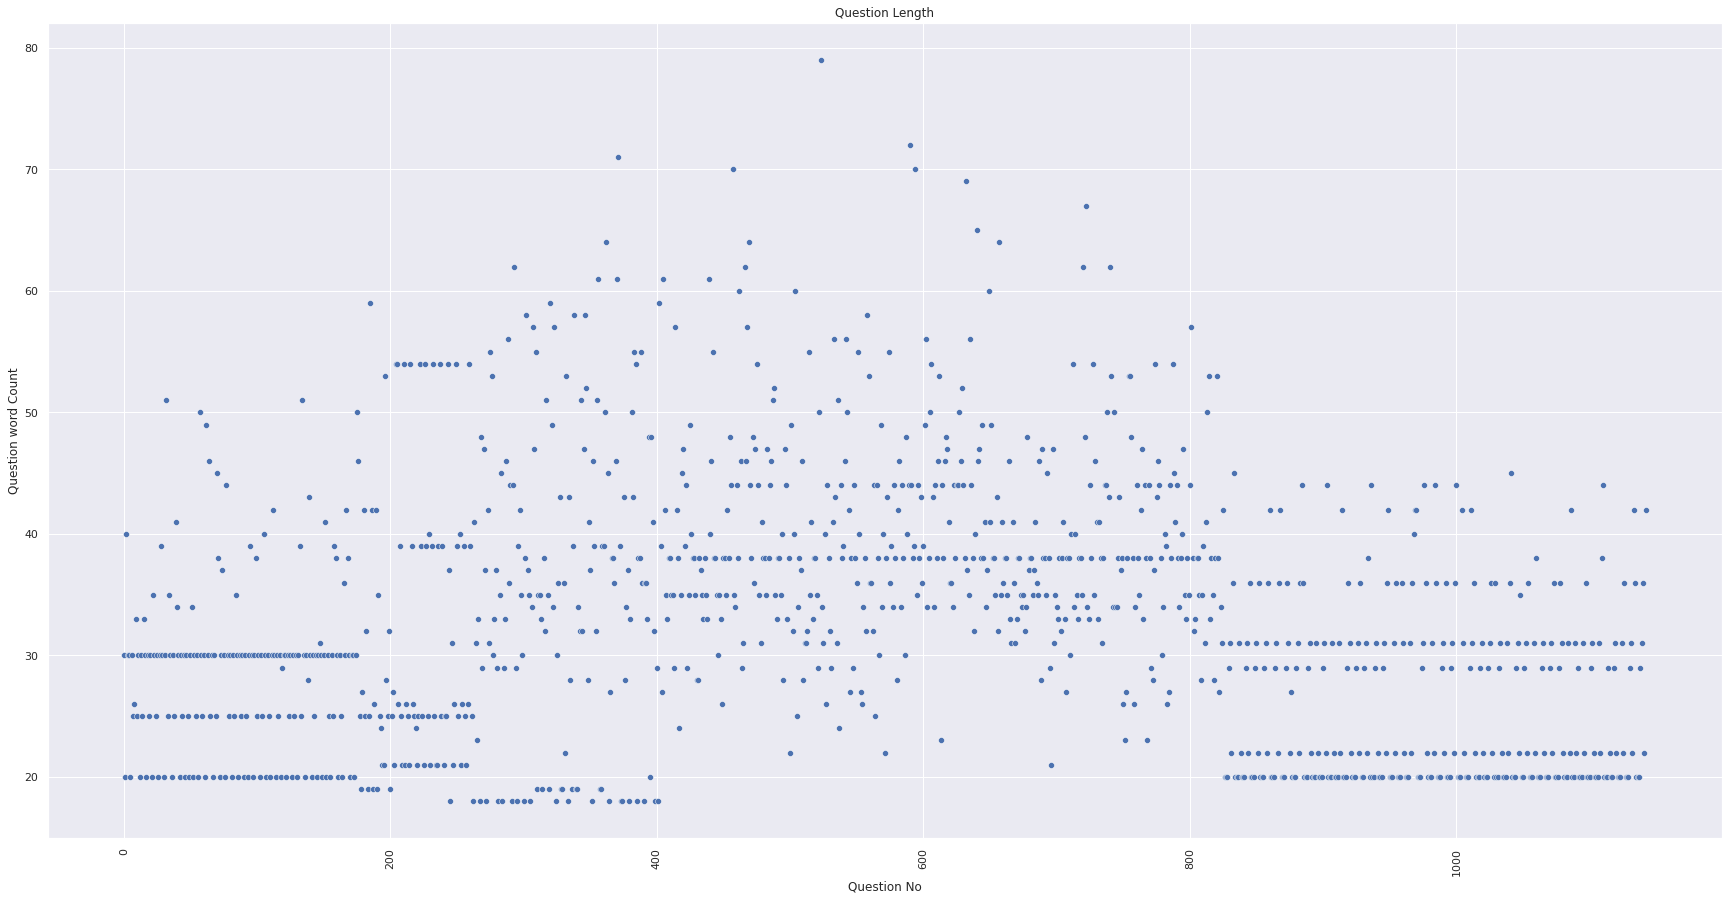

In [ ]:
que_len = []

for i in range(0,len(questions)):
    que_len.append(len(questions[i]))

# print((passage_len))
plot_sns(que_len, 'que_len', (30,15), sns.scatterplot, xlabel = "Question No", ylabel = "Question word Count", title = "Question Length")

In [ ]:
que_MMA = {'max':max(que_len),'min':min(que_len),'avg':np.average(que_len)}
print(que_MMA)

{'max': 79, 'min': 18, 'avg': 33.25109361329834}


In [ ]:
print(len(answer_text[1]))

5


[132   5  66 ...  11   8  21]


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


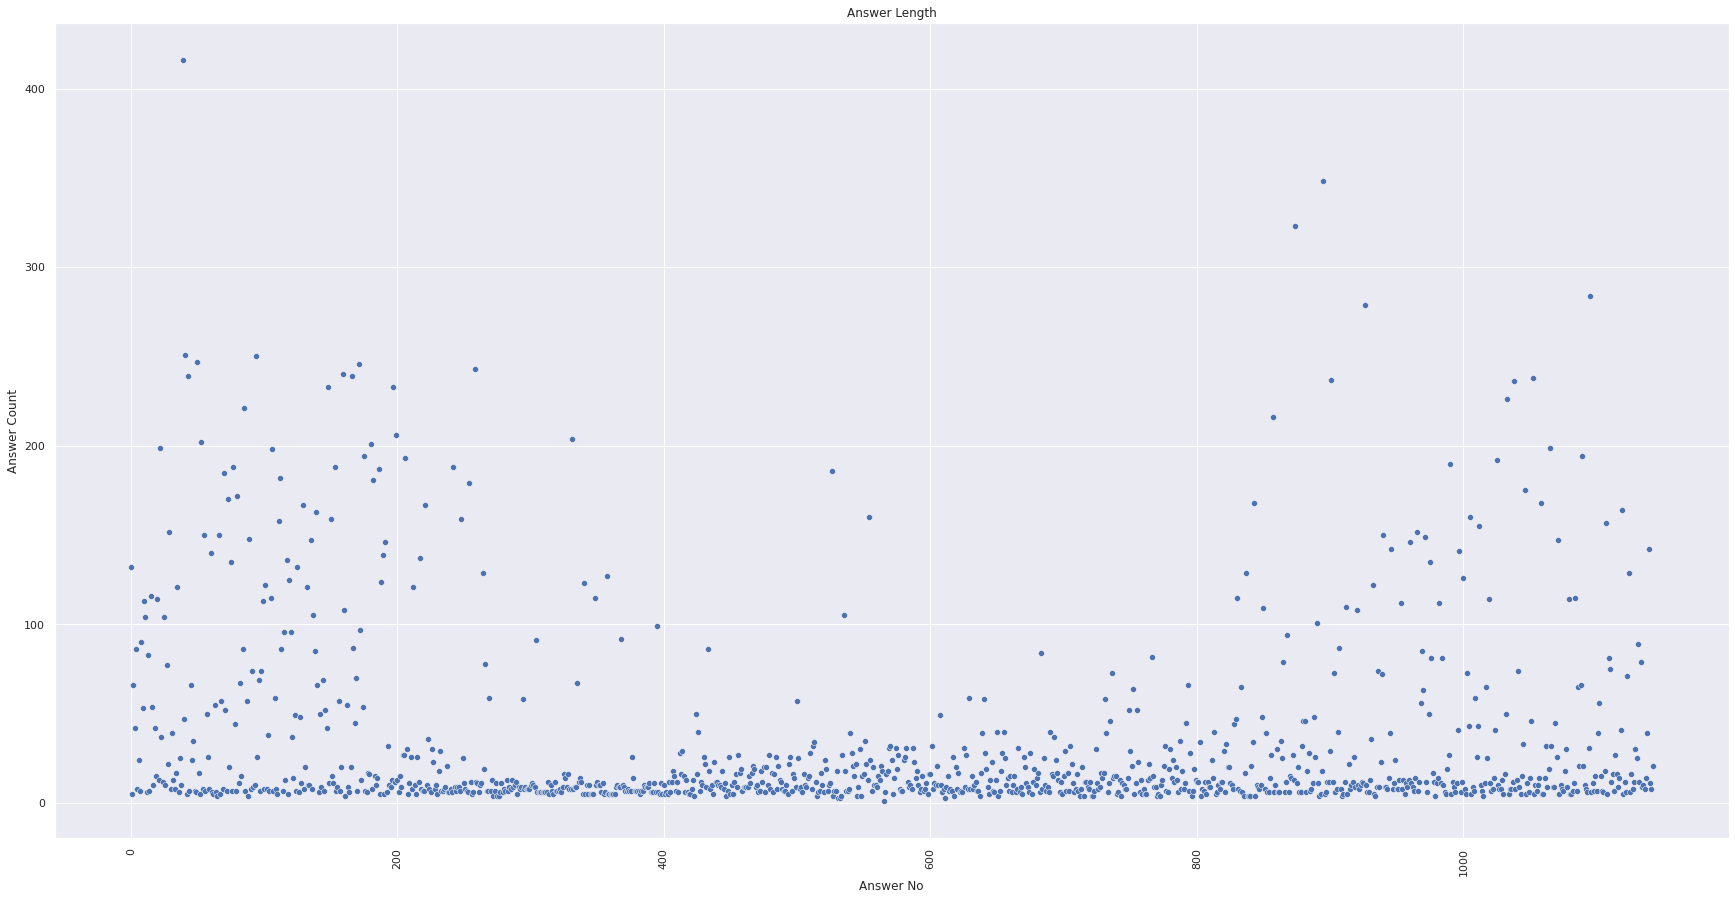

In [ ]:
answer_text_len = []

for i in range(0,len(answer_text)):
    answer_text_len.append(len(answer_text[i]))

# print((passage_len))
plot_sns(answer_text_len, 'answer_text_len', (30,15), sns.scatterplot,xlabel = "Answer No", ylabel = "Answer Count", title = "Answer Length")

In [ ]:
answer_text_MMA = {'max':max(answer_text_len),'min':min(answer_text_len),'avg':np.average(answer_text_len)}
print(answer_text_MMA)

{'max': 416, 'min': 1, 'avg': 32.52580927384077}


In [ ]:
que_cat = dict()
que_types = set()

for i in range(0,len(questions)):
    x = questions[i].lower().split(' ')
    que_types.add(x[0])

print(que_types)
print(len(que_types))
que_types=list(que_types)

for i in range(len(que_types)):
    que_cat[que_types[i]] = 0
print(que_cat)


for i in range(0,len(questions)):
    x = questions[i].lower().split(' ')
    y = x[0]
    # print(y)
    que_cat[y]+= 1

{'', 'muslim', 'vice', 'uzbekistan', 'bhuj', 'ankleshwar', 'originally', 'uganda', 'yemen', 'surat', "ankleshwar's", 'where', 'anand', 'ukrainian', 'in', 'very', 'bangalore', 'vadodara', 'himatnagar', 'north', 'mandvi', 'which', 'uruguay', 'vapi', 'tuvalu', 'population', 'king', "what's", 'bhavnagar', 'diu', 'gandhidham', 'slums', 'usa', 'when', 'vanuatu', 'ukraine', 'according', 'the', '8', 'south', 'trinidad', 'ahmedabad', 'millions', 'porbandar', 'at', 'total', 'bharuch', 'godhra', 'archipelago', 'togo', "togo's", 'morbi', 'palanpur', 'nadiad', 'president', 'rajkot', 'venezuela', 'dahod', 'how', 'zimbabwe', 'veraval', 'gandhinagar', 'who', 'one', 'junagadh', 'uparkot', 'what', 'united', 'this', 'northern'}
70
{'': 0, 'muslim': 0, 'vice': 0, 'uzbekistan': 0, 'bhuj': 0, 'ankleshwar': 0, 'originally': 0, 'uganda': 0, 'yemen': 0, 'surat': 0, "ankleshwar's": 0, 'where': 0, 'anand': 0, 'ukrainian': 0, 'in': 0, 'very': 0, 'bangalore': 0, 'vadodara': 0, 'himatnagar': 0, 'north': 0, 'mandvi'

In [ ]:
print(len(que_types))

70


In [ ]:
que_cat.keys()

dict_keys(['', 'muslim', 'vice', 'uzbekistan', 'bhuj', 'ankleshwar', 'originally', 'uganda', 'yemen', 'surat', "ankleshwar's", 'where', 'anand', 'ukrainian', 'in', 'very', 'bangalore', 'vadodara', 'himatnagar', 'north', 'mandvi', 'which', 'uruguay', 'vapi', 'tuvalu', 'population', 'king', "what's", 'bhavnagar', 'diu', 'gandhidham', 'slums', 'usa', 'when', 'vanuatu', 'ukraine', 'according', 'the', '8', 'south', 'trinidad', 'ahmedabad', 'millions', 'porbandar', 'at', 'total', 'bharuch', 'godhra', 'archipelago', 'togo', "togo's", 'morbi', 'palanpur', 'nadiad', 'president', 'rajkot', 'venezuela', 'dahod', 'how', 'zimbabwe', 'veraval', 'gandhinagar', 'who', 'one', 'junagadh', 'uparkot', 'what', 'united', 'this', 'northern'])

In [ ]:
que_cat

{'': 1,
 'muslim': 1,
 'vice': 1,
 'uzbekistan': 1,
 'bhuj': 1,
 'ankleshwar': 1,
 'originally': 1,
 'uganda': 1,
 'yemen': 2,
 'surat': 3,
 "ankleshwar's": 1,
 'where': 96,
 'anand': 2,
 'ukrainian': 1,
 'in': 7,
 'very': 1,
 'bangalore': 1,
 'vadodara': 3,
 'himatnagar': 2,
 'north': 1,
 'mandvi': 2,
 'which': 134,
 'uruguay': 4,
 'vapi': 2,
 'tuvalu': 1,
 'population': 2,
 'king': 1,
 "what's": 65,
 'bhavnagar': 1,
 'diu': 1,
 'gandhidham': 1,
 'slums': 1,
 'usa': 5,
 'when': 23,
 'vanuatu': 1,
 'ukraine': 1,
 'according': 1,
 'the': 25,
 '8': 1,
 'south': 1,
 'trinidad': 1,
 'ahmedabad': 2,
 'millions': 1,
 'porbandar': 3,
 'at': 1,
 'total': 2,
 'bharuch': 2,
 'godhra': 2,
 'archipelago': 1,
 'togo': 1,
 "togo's": 1,
 'morbi': 1,
 'palanpur': 2,
 'nadiad': 2,
 'president': 1,
 'rajkot': 5,
 'venezuela': 1,
 'dahod': 1,
 'how': 32,
 'zimbabwe': 1,
 'veraval': 4,
 'gandhinagar': 1,
 'who': 39,
 'one': 1,
 'junagadh': 2,
 'uparkot': 1,
 'what': 625,
 'united': 4,
 'this': 1,
 'northe

In [ ]:
who = 0
when = 0
where = 0
how = 0
whats = 0
what = 0
which = 0
whom = 0
iis = 0
are = 0
was = 0
were = 0
extra = 0

for i in range(0,len(questions)):
    questions[i] = questions[i].replace("?", "")
    x = questions[i].lower().split(' ')
    if 'who' in x:
        who += 1
    elif 'when' in x:
        when += 1
    elif 'where' in x:
        where += 1
    elif 'how' in x:
        how += 1
    elif "what's" in x:
        whats += 1
    elif 'what' in x:
        what += 1
    elif 'which' in x:
        which += 1
    elif 'whom' in x:
        whom += 1
    elif 'is' in x:
        iis += 1
    elif 'are' in x:
        are += 1
    elif 'was' in x:
        was += 1
    elif 'were' in x:
        were += 1
    else:
        print(x)
        extra += 1

print('who: ', who)
print('when: ', when)
print('where: ', where)
print('how: ', how)
print("what's: " , whats)
print('what: ', what)
print('which: ', which)
print('whom: ', whom)
print('is: ', iis)
print('are: ', are)
print('was: ', was)
print('were: ', were)
print('extra: ', extra)

['population', 'of', 'the', 'capital', 'city']
['population', 'of', 'the', 'country', 'in', '2013']
who:  43
when:  23
where:  99
how:  42
what's:  65
what:  668
which:  178
whom:  12
is:  8
are:  2
was:  1
were:  0
extra:  2


In [ ]:
q = ['what', 'which', 'where', "what's", 'how', 'who', 'when', 'whom', 'is', 'are', 'was', 'were', 'extra']
v = [647,178,98,65,42,40,23,12,8,2,1,0,2]

In [ ]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


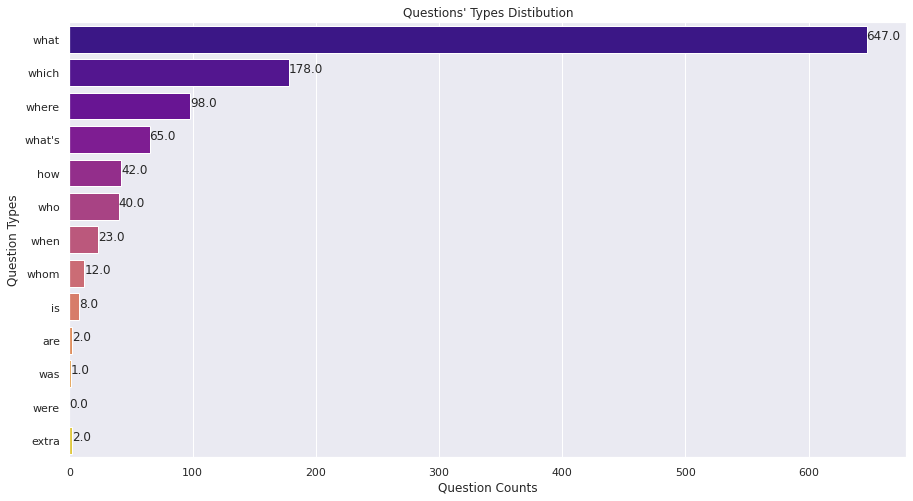

In [ ]:
sns.set(rc={'figure.figsize':(15, 8)})
ax = sns.barplot(v,q, palette='plasma')
# ax.bar_label(ax.containers[0])

ax.tick_params(axis='x')
ax.set(ylabel="Question Types", xlabel="Question Counts", title="Questions' Types Distibution")
# show_values(ax)
#show values on barplot
show_values(ax, "h", space=0)
fig = ax.get_figure()
fig.savefig('/content/drive/MyDrive/297_NLP/Final_Project/que_types', dpi = 400) 

In [ ]:
plot_dict = {
    'Passage_length': passage_MMA,
    'Question_length': que_MMA,
    'ans_length': answer_text_MMA,
}

In [ ]:
plot_dict

{'Passage_length': {'max': 2925, 'min': 151, 'avg': 844.0904255319149},
 'Question_length': {'max': 79, 'min': 18, 'avg': 33.25109361329834},
 'ans_length': {'max': 416, 'min': 1, 'avg': 32.52580927384077}}

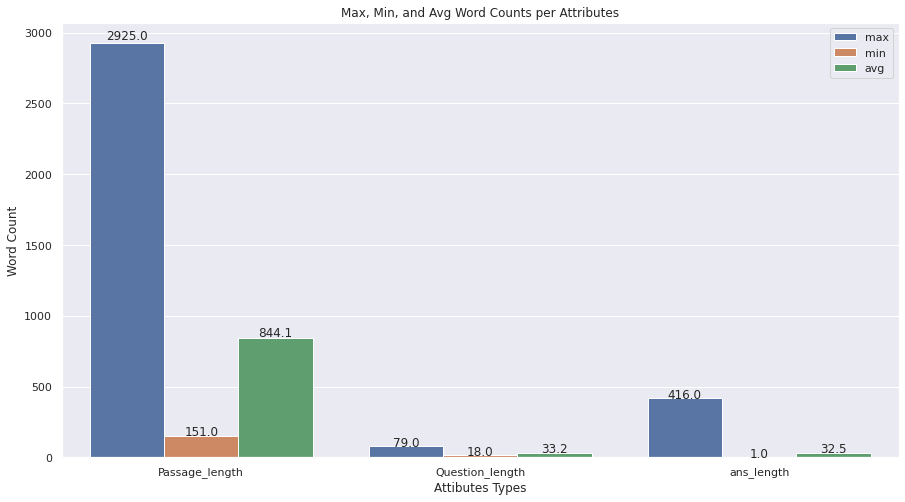

In [ ]:
d = {
    'x':    ['Passage_length', 'Passage_length',  'Passage_length', 'Question_length', 'Question_length', 'Question_length', 'ans_length', 'ans_length', 'ans_length'],
    'y':    [   2925,    151,   844.09,     79,    18,     33.25,    416,    1,   32.52],
    'group':[  'max',  'min', 'avg',   'max',  'min',  'avg',   'max',  'min',  'avg']
}

# sns.barplot(x='x', y='y', hue="group", data=d)


sns.set(rc={'figure.figsize':(15, 8)})
ax = sns.barplot(x='x', y='y', hue="group", data=d)
ax.set(ylabel="Word Count", xlabel="Attibutes Types", title="Max, Min, and Avg Word Counts per Attributes")
ax.tick_params(axis='x')

#show values on barplot
show_values(ax, "v", space=0)
fig = ax.get_figure()
fig.savefig('/content/drive/MyDrive/297_NLP/Final_Project/min_max_length', dpi = 400) 